In [1]:
# Import Libraries
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0' 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#####################################################################
# Input parameters
#####################################################################

# Load the data
data_file = '/kaggle/input/heat-data/data.csv'
df = pd.read_csv(data_file)

T_hold = 180 # C, ambient temperature
df["feature"]=T_hold-10*np.exp(-0.1 * (df["heat_transfer_coefficient"]))
X_columns = ['tool_thickness', 'feature']
Y_column = 'max_temperature'

#####################################################################
# Functions
#####################################################################

def build_and_train_nn(X_train, Y_train, X_test, Y_test):
    # Build a neural network model
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        *[Dense(16, activation='relu') for _ in range(3)],  # Three hidden layers
        Dense(1)
    ])

    model.compile(optimizer=Adamax(learning_rate=0.01), loss='mse')
    model.fit(X_train, Y_train, epochs=100, batch_size=16, verbose=0, validation_data=(X_test, Y_test))

    # Evaluate the model
    Y_pred_test = model.predict(X_test)
    r2_test = round(r2_score(Y_test, Y_pred_test) * 100, 1)
    return model, r2_test



2025-08-25 09:46:46.280790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756115206.445346      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756115206.494773      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#####################################################################
# Main Code
#####################################################################

# Extract features (X) and target variable (Y)
X = df[X_columns]
Y = df[Y_column].values

# Standardize the data
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_Y = StandardScaler()
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1)).flatten()

# Split the main data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.25, random_state=42)

# Build and train the neural network model
nn_model, nn_r2_test = build_and_train_nn(X_train, Y_train, X_test, Y_test)
print(f"Neural Network R2 Test Score: {nn_r2_test}")


I0000 00:00:1756115222.426623      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756115222.427321      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1756115224.975054     129 service.cc:148] XLA service 0x7d885800c970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756115224.975486     129 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756115224.975509     129 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756115225.154340     129 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756115225.824899     129 device_compiler.h:188] Compiled clust

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Neural Network R2 Test Score: 99.7


In [4]:

# Generate meshgrid for plotting
tool_thickness_range = np.linspace(0.001, 0.05, 100)
heat_transfer_coefficient_range = np.linspace(10, 100, 100)
tool_thickness_mesh, heat_transfer_coefficient_mesh = np.meshgrid(tool_thickness_range, heat_transfer_coefficient_range)
feature_mesh=T_hold - 10*np.exp(-0.1 * (heat_transfer_coefficient_mesh))
input_mesh = np.c_[tool_thickness_mesh.ravel(), feature_mesh.ravel()]

# Scale the input mesh
input_mesh_scaled = scaler_X.transform(input_mesh)

# Predict using the trained model and inverse scale the predictions
predicted_mesh = scaler_Y.inverse_transform(nn_model.predict(input_mesh_scaled)).reshape(tool_thickness_mesh.shape)

# Load the entire dataset
df_all = pd.read_csv('/kaggle/input/heat-all-file/data_all.csv')



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


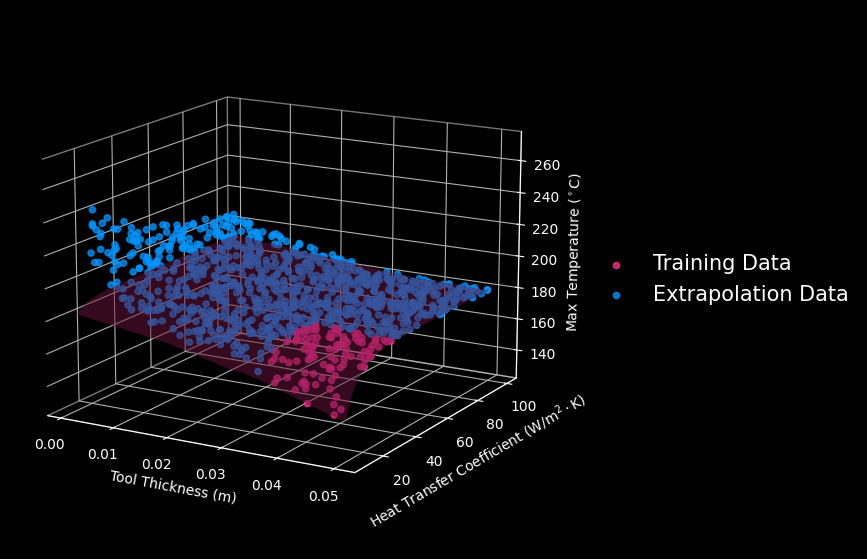

In [5]:
# Plotting
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('black')
fig.patch.set_facecolor('black')
ax.plot_surface(tool_thickness_mesh, heat_transfer_coefficient_mesh, predicted_mesh, color='#FF2F92', alpha=0.50, rstride=100, cstride=100)
ax.scatter(df['tool_thickness'], df['heat_transfer_coefficient'], df['max_temperature'], c='#FF2F92', marker='o', alpha=0.75, label='Training Data', s=20)
ax.scatter(df_all['tool_thickness'], df_all['heat_transfer_coefficient'], df_all['max_temperature'], c='#0096FF', marker='o', alpha=0.75, label='Extrapolation Data', s=20)

# Set labels and style
ax.set_xlabel("Tool Thickness (m)", color='white')
ax.set_ylabel(r"Heat Transfer Coefficient (W/m$^2\cdot$K)", color='white')
ax.set_zlabel(r"Max Temperature ($^\circ$C)", color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.tick_params(axis='z', colors='white')
ax.w_xaxis.line.set_color("white")
ax.w_yaxis.line.set_color("white")
ax.w_zaxis.line.set_color("white")
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_zlim(125, 275)
ax.view_init(elev=15, azim=-60)
ax.legend(fontsize=15, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, labelcolor='white')
plt.show()